In [1]:
#  Importation des librairies

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras import metrics
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle
import cv2
import imutils
from imutils.contours import sort_contours
from keras.layers import Dropout
import mlflow
import mlflow.sklearn
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse

# from src import fonctions

Using TensorFlow backend.


In [2]:
# Chemins du projet
DATA_ROOT = 'data/'
MODELE_PATH = DATA_ROOT + 'model.h5'
TRAINING_PATH = DATA_ROOT + 'train'
TESTING_PATH = DATA_ROOT + 'test'

# Autres paramètres
batch_size = 32
num_classes = 32
epochs = 35
# img_size = 28
img_size = 32
input_shape = (img_size, img_size, 3)
validation_split = 0.3

In [3]:


#Génération des images

train_datagen = ImageDataGenerator(         
    horizontal_flip = True
)      

test_datagen = ImageDataGenerator(rescale = 1./255)


# Importation des images du training

image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split)

train_generator = image_data_generator.flow_from_directory(
    ### Choix de mon repertoire ###
    directory = TRAINING_PATH,
    ### Je converti les images de leur taille d'origine à notre target_size ###                    
    target_size = (img_size,img_size),
    ### Nombre batch_size qui fait référence au nombre d'exemples d'entraînement utilisés dans une itération ###                                      
    batch_size = batch_size,
    ### Je definis le class_mode sur "catégorical" indiquant que nous avons plusieurs classes (a à z) à prédire ###          
    class_mode = "categorical",                              

)

# Importation des images du test

test_generator = test_datagen.flow_from_directory(
    directory = TESTING_PATH,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = "categorical",

)

Found 1600 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [4]:
# Récupération de la variable conv
valeurConv = 32

# Mise en place de la convolution
model = Sequential()



model.add(Conv2D(valeurConv, (3, 3), padding='same', input_shape = input_shape, activation = "relu"))


model.add(Conv2D(valeurConv, (3, 3), padding='same', input_shape = input_shape))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

### Une fois notre architecture CNN définie, nous compilons le modèle à l'aide de l'optimiseur Adam ###
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 131076    
Total params: 141,220
Trainable params: 141,220
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Entrainenment du model

entrainement = model.fit_generator(
    train_generator,
    steps_per_epoch = batch_size,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = batch_size
)

score = model.evaluate(train_generator, verbose=0)
print("Test de perte:", score[0])
print("Test de précision:", score[1])
print("Enregistrement du modèle...")
model.save(MODELE_PATH)
print("Modèle enregistré.")


Epoch 1/35
32/32 [==============================] - 9s 267ms/step - loss: 142.9992 - accuracy: 0.4863 - val_loss: 1.3148 - val_accuracy: 0.2461
Epoch 2/35
32/32 [==============================] - 8s 249ms/step - loss: 15.4068 - accuracy: 0.7168 - val_loss: 1.2807 - val_accuracy: 0.3506
Epoch 3/35
32/32 [==============================] - 8s 244ms/step - loss: 6.4900 - accuracy: 0.7529 - val_loss: 1.3202 - val_accuracy: 0.1865
Epoch 4/35
32/32 [==============================] - 8s 254ms/step - loss: 3.4604 - accuracy: 0.8232 - val_loss: 1.3584 - val_accuracy: 0.2520
Epoch 5/35
32/32 [==============================] - 8s 247ms/step - loss: 2.6306 - accuracy: 0.8486 - val_loss: 1.3398 - val_accuracy: 0.2607
Epoch 6/35
32/32 [==============================] - 8s 248ms/step - loss: 1.8107 - accuracy: 0.8691 - val_loss: 1.3386 - val_accuracy: 0.1611
Epoch 7/35
32/32 [==============================] - 8s 251ms/step - loss: 1.4513 - accuracy: 0.8857 - val_loss: 1.3859 - val_accuracy: 0.2148
Ep

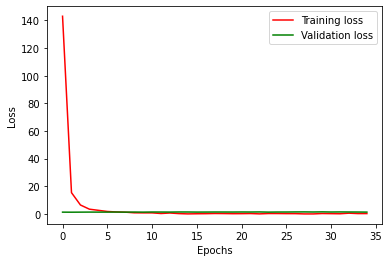

In [6]:
# Affichage des pertes

plt.plot(entrainement.history['loss'], color='red', label='Training loss')
plt.plot(entrainement.history['val_loss'],  color='green', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

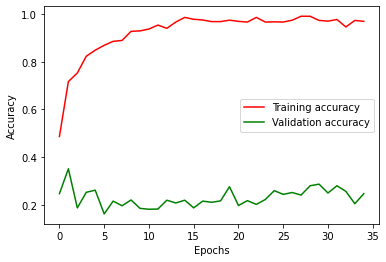

In [7]:
# Affichage des performances

plt.plot(entrainement.history['accuracy'], color='red', label='Training accuracy')
plt.plot(entrainement.history['val_accuracy'],  color='green', label='Validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [8]:
# Chargement de l'image de test

from keras.models import Model

layer_outputs = [layer.output for layer in model.layers]

test_image = "assets/tigre.jpg"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32, 1))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

# Manipulation de l'image de test

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*13.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')

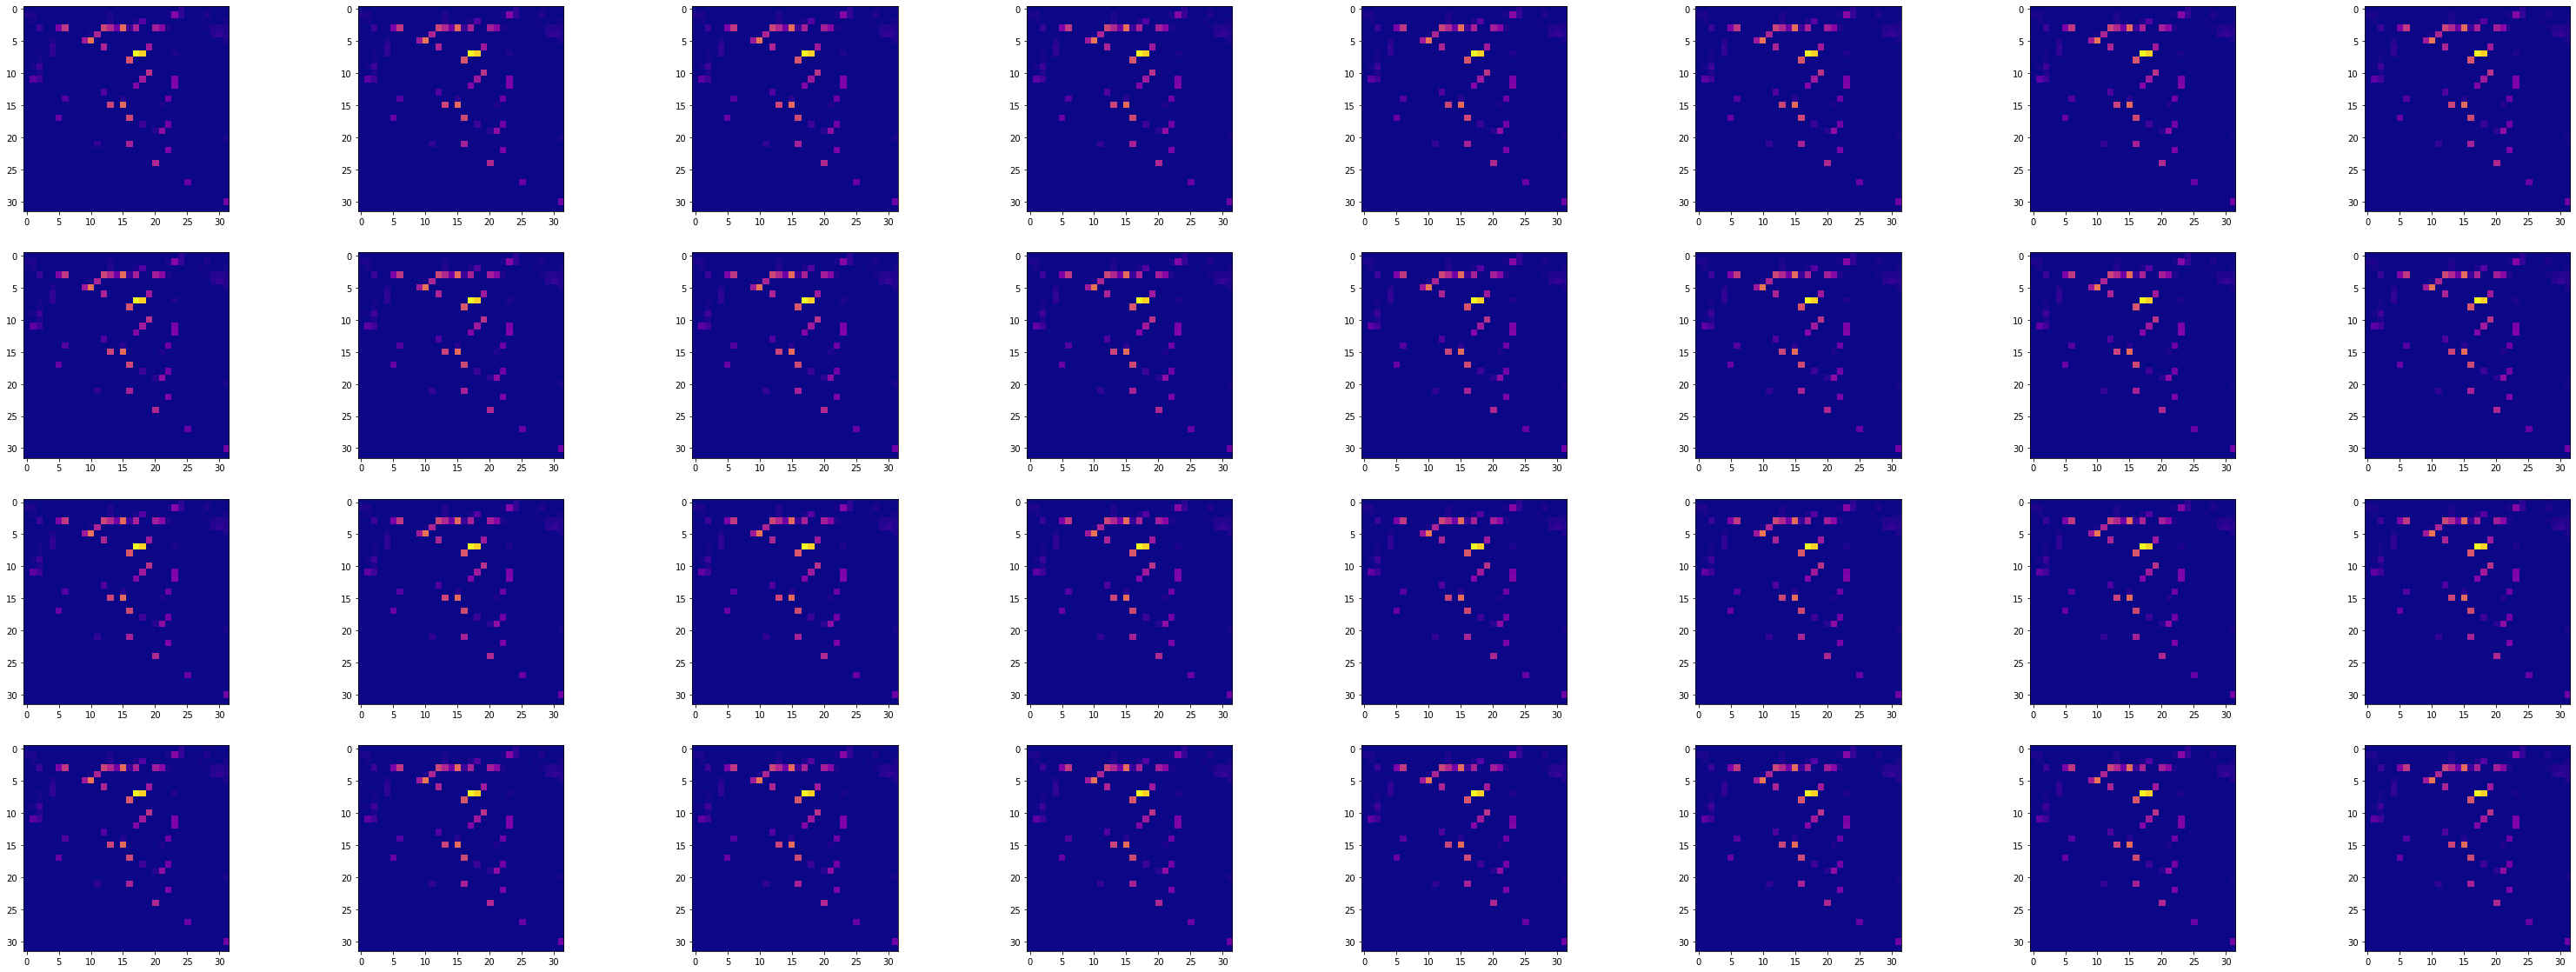

In [9]:
display_activation(activations, 8, 4, 0)

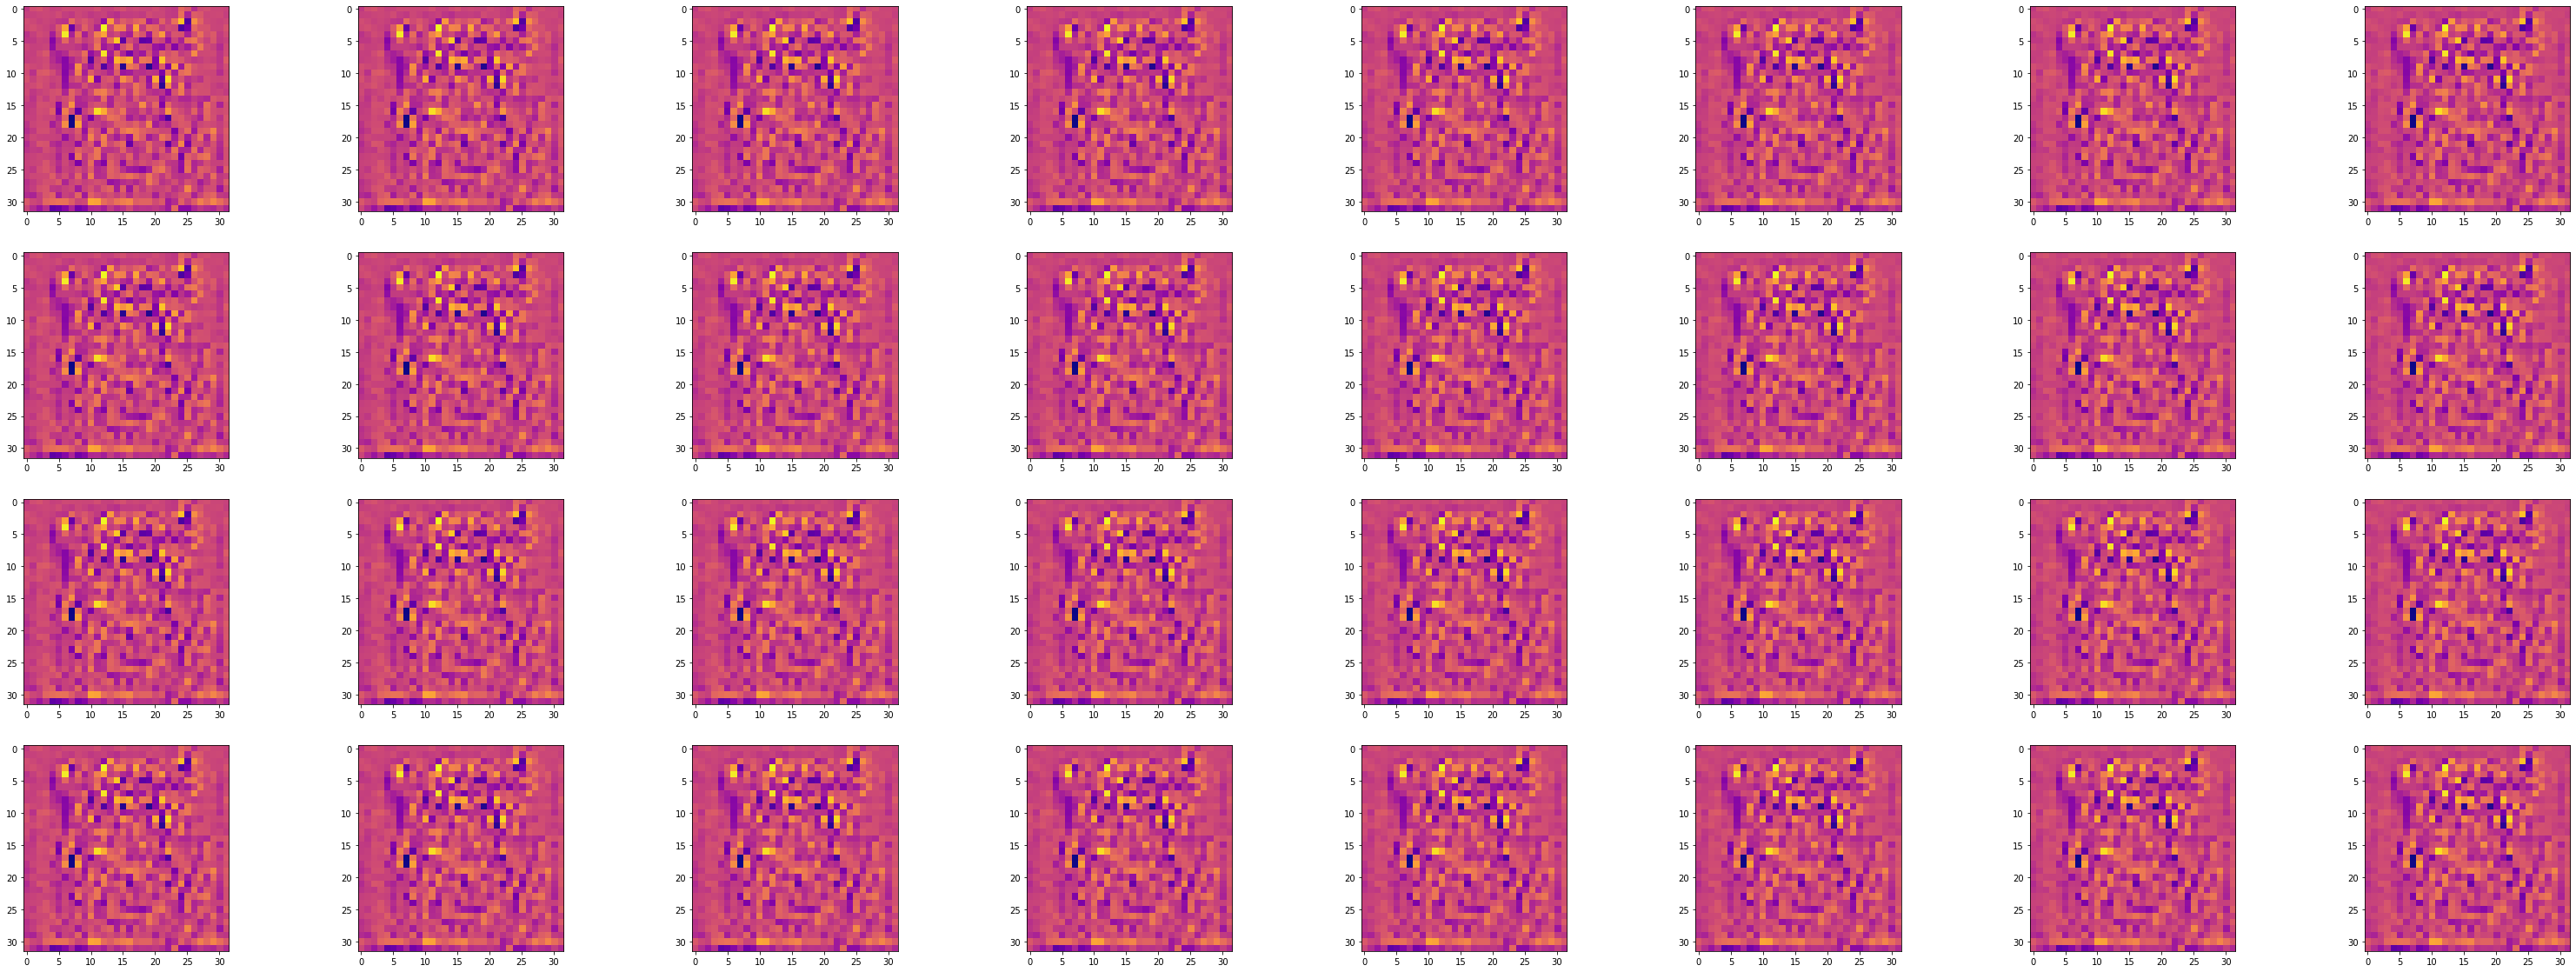

In [10]:
display_activation(activations, 8, 4, 1)

In [11]:
# Chargement du modèle

model = load_model('data/model.h5')

In [12]:
# Chargement de l'image

test_image1 = image.load_img('assets/tigre.jpg',target_size =(32,32))

In [13]:
# Prédiction avec l'image dans le but d'identifier sa catégorie dédiée

identification = ""

test_image = image.img_to_array(test_image1) 
test_image = np.expand_dims(test_image, axis =0) 
result = model.predict(test_image) 
print(result) 
if result[0][0]==1:
    identification = "apple"
    print("apple") 
elif result[0][1]==1: 
    identification = "baby"
    print('baby') 
elif result[0][2]==1: 
    identification = "bus"
    print("bus") 
elif result[0][3]==1: 
    identification = "tiger"
    print('tiger')
else: 
    identification = "Non défini"
    print('Non défini')

[[0. 0. 0. 1.]]
tiger


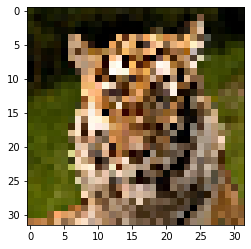

In [14]:
# Affichage de l'image importée tel reconnue par la détection

plt.imshow(test_image1)

In [15]:
# utilisation de MLfLow

with mlflow.start_run():
        lr = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=42)
        
        # Enregistrement des valeurs pour MLflow
        mlflow.log_param("epoch", epochs)
        mlflow.log_param("conv", valeurConv)
        mlflow.log_param("loss", score[0])
        mlflow.log_param("accuracy", score[1])
        mlflow.log_param("prediction", result)
        mlflow.log_param("identification", identification)

        # Enregistrement du modèle pour MLflow
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
        else:
            mlflow.sklearn.log_model(lr, "model")